In [2]:
!pip install easyocr matplotlib numpy

In [43]:
import os
import easyocr
import cv2
from matplotlib import pyplot as plt
import numpy as np
from skimage import io
import plotly.express as px

In [4]:
reader = easyocr.Reader(['en'])

/home/iduadmin/miniconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [5]:
INPUT_WIDTH =  640
INPUT_HEIGHT = 640

In [7]:
net = cv2.dnn.readNetFromONNX('../OCR/yolov5/runs/train/Model5/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [121]:
# extrating text
def extract_text(image,bbox):
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]
    
    if 0 in roi.shape:
        print('no number')
        return []
    else:
        extracted_text = ""
        results = reader.readtext(roi, paragraph=True)
        for (box, text) in results:
            extracted_text = extracted_text + "\n" + text

        print(extracted_text)
        return extracted_text

In [165]:
def get_detections(img,net):
    # 1.CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image[:,:, :3]
    # 2. GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

def non_maximum_supression(input_image,detections):
    
    # 3. FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE
    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # 4.1 CLEAN
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    
    # 4.2 NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)
    return boxes_np, confidences_np, index

def drawings(image,boxes_np,confidences_np,index):
    # 5. Drawings
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])
            
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+25),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)
    
    if boxes_np == []:
        licence_text = ""
        results = reader.readtext(image, paragraph=True)
        for box, text in results:
            print(box)

            licence_text = licence_text + " " + text
        
    print("Licence plate not detected \nText found:", licence_text)
    return image

In [166]:
# predictions flow with return result
def yolo_predictions(img,net):
    # step-1: detections
    input_image, detections = get_detections(img,net)
    # step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    # step-3: Drawings
    result_img = drawings(img,boxes_np,confidences_np,index)
    return result_img

In [167]:
img = io.imread('/home/iduadmin/PycharmProjects/OCR/Task3_images/car/NK09 FJY.jpeg')
results = yolo_predictions(img,net)

[[78, 14], [136, 14], [136, 38], [78, 38]]
[[81, 123], [119, 123], [119, 137], [81, 137]]
Licence plate not detected 
Text found:  POL Nku9 FJt



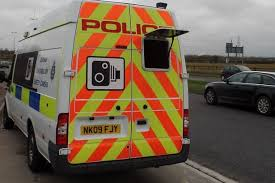

In [113]:
fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()